# Time Series Analysis ARIMA application
based on Kaggle: <https://www.kaggle.com/c/web-traffic-time-series-forecasting/data>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# preprocessing data(english version of wikipedia only)
train = pd.read_csv('/content/drive/My Drive/Kaggle/web_traffic/train_1.csv', header = 0)
train = train.drop(train.columns[1:185], axis = 1)
train = pd.melt(train, id_vars = 'Page', value_vars = train.columns[1:]).rename(columns = {'variable':'Date', 'value':'Visits'}).sort_values(by = ['Page', 'Date'])
train_en = train[train['Page'].str.contains('en.wikipedia.org', regex = False)]
train_en = train_en.fillna(0)

names = []; access = []; agents = []
for value in train_en['Page'].values:
  split_list = value.split('_')
  names.append(split_list[0]); access.append(split_list[-2]); agents.append(split_list[-1])

train_en['Name'] = names
train_en['Access'] = access
train_en['Agent'] = agents

train_en['Date'] = pd.to_datetime(train_en['Date'], format = '%Y-%m-%d')

train_en['Month'] = train_en['Date'].dt.month
train_en['Day'] = train_en['Date'].dt.day
train_en['Weekday'] = train_en['Date'].dt.weekday

In [4]:
train_en.head()

,Page,Date,Visits,Name,Access,Agent,Month,Day,Weekday
37206,!vote_en.wikipedia.org_all-access_all-agents,2016-01-01,3.0,!vote,all-access,all-agents,1,1,4
182269,!vote_en.wikipedia.org_all-access_all-agents,2016-01-02,2.0,!vote,all-access,all-agents,1,2,5
327332,!vote_en.wikipedia.org_all-access_all-agents,2016-01-03,2.0,!vote,all-access,all-agents,1,3,6
472395,!vote_en.wikipedia.org_all-access_all-agents,2016-01-04,2.0,!vote,all-access,all-agents,1,4,0
617458,!vote_en.wikipedia.org_all-access_all-agents,2016-01-05,3.0,!vote,all-access,all-agents,1,5,1


In [5]:
corr = pd.pivot_table(train_en, index = 'Month', columns = 'Name', values = 'Visits').corr()
drop_names = corr[corr['!vote'].isna()==True].index.tolist()

for name in drop_names:
  train_en = train_en[train_en['Name'] != name]

corr = pd.pivot_table(train_en, index = 'Month', columns = 'Name', values = 'Visits').corr()

import scipy.cluster.hierarchy as spc
def hierarchical_clustering(correlation, method, param): 
    pdist = spc.distance.pdist(correlation)
    linkage = spc.linkage(pdist, method=method)
    idx = spc.fcluster(linkage, param * pdist.max(), 'distance')
    cluster = pd.DataFrame({'Name':correlation.index, 'Cluster':idx})   
    return cluster

cluster_1 = hierarchical_clustering(corr,'complete',0.7)
print('Number of clusters: ',cluster_1['Cluster'].nunique())
train_cluster = pd.merge(train_en, cluster_1, on='Name')

Number of clusters:  12


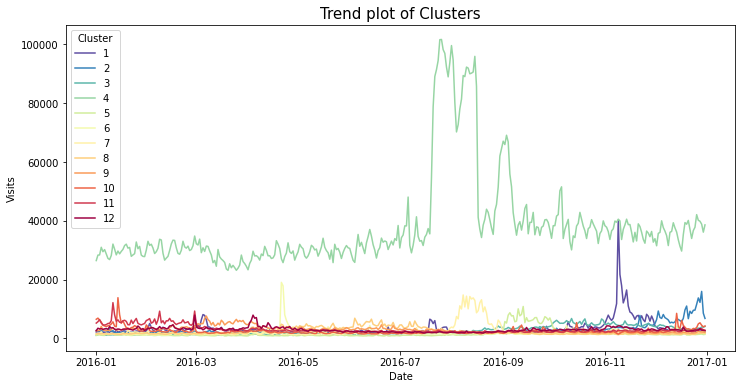

In [6]:
plt.figure(figsize=(12,6))
c_mean = train_cluster.groupby(['Cluster','Date'])['Visits'].mean().reset_index()
sns.lineplot(data=c_mean, x= 'Date', y='Visits',hue='Cluster', legend = 'full', palette = 'Spectral_r')
plt.title('Trend plot of Clusters', fontsize = 15)
plt.show()

## 1. ARIMA

*   분석대상: Cluster 4에 있는 Page 명 중 하나 선택(시간이 되면 다른 클러스터도 선택해보기)
*   ARIMA(비계절성)/SARIMA(계절성)
*   이동평균법/지수평활법
*   ACF/PACF -> p,d,q 결정



In [7]:
train_cluster.groupby(['Name','Cluster'])['Visits'].mean().sort_values(ascending = False)[:5]

Name            Cluster
Main            4          6.691799e+06
Special:Search  4          1.187800e+06
Special:Book    2          1.872447e+05
404.php         2          1.712911e+05
XHamster        9          9.779543e+04
Name: Visits, dtype: float64

In [8]:
# 위키피디아 메인 페이지 접속량이 가장 많음(너무나 당연!) - Main Page 접속량이 전체 접속량을 대변할 수 있다고 판단
c4 = train_cluster[train_cluster['Cluster']== 4]
c4.groupby(['Name','Cluster'])['Visits'].mean().sort_values(ascending = False)[:5]

Name               Cluster
Main               4          6.691799e+06
Special:Search     4          1.187800e+06
Okto               4          2.136941e+04
Stranger           4          1.820439e+04
Wikipedia:Contact  4          1.343561e+04
Name: Visits, dtype: float64

### (1) Moving Average

In [9]:
# Main page web traffic data
df = train_en[train_en['Name']=='Main']

df['ma_week'] = np.round(df['Visits'].rolling(window = 7, min_periods = 1).mean(),0)
df['ma_month'] = np.round(df['Visits'].rolling(window = 30, min_periods = 1).mean(),0)
df['ma_quarter'] = np.round(df['Visits'].rolling(window = 121, min_periods = 1).mean(),0)
df['mv'] = np.round(df['Visits'].rolling(window = 121, min_periods = 1).std(),0)

df.head()

,Page,Date,Visits,Name,Access,Agent,Month,Day,Weekday,ma_week,ma_month,ma_quarter,mv
9775,Main_Page/_en.wikipedia.org_desktop_all-agents,2016-01-01,182.0,Main,desktop,all-agents,1,1,4,182.0,182.0,182.0,NaN
154838,Main_Page/_en.wikipedia.org_desktop_all-agents,2016-01-02,236.0,Main,desktop,all-agents,1,2,5,209.0,209.0,209.0,38.0
299901,Main_Page/_en.wikipedia.org_desktop_all-agents,2016-01-03,240.0,Main,desktop,all-agents,1,3,6,219.0,219.0,219.0,32.0
444964,Main_Page/_en.wikipedia.org_desktop_all-agents,2016-01-04,367.0,Main,desktop,all-agents,1,4,0,256.0,256.0,256.0,78.0
590027,Main_Page/_en.wikipedia.org_desktop_all-agents,2016-01-05,351.0,Main,desktop,all-agents,1,5,1,275.0,275.0,275.0,80.0


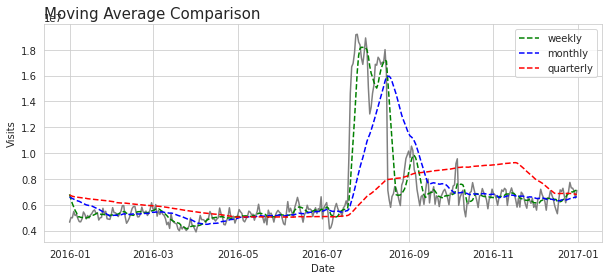

In [10]:
plt.figure(figsize = (10,4))
sns.set_style('whitegrid')
sns.lineplot(data = df, x = 'Date', y = 'Visits', color = 'grey', ci=None)
sns.lineplot(data = df, x = 'Date', y = 'ma_week', color = 'green', ci=None, linestyle = '--', label = 'weekly')
sns.lineplot(data = df, x = 'Date', y = 'ma_month', color = 'blue', ci=None, linestyle = '--', label = 'monthly')
sns.lineplot(data = df, x = 'Date', y = 'ma_quarter', color = 'red', ci=None, linestyle = '--', label = 'quarterly')
plt.title('Moving Average Comparison', fontsize = 15, loc = 'left'); plt.ylim()
plt.show()

### (2) Seasonal Decomposition

In [11]:
# reshape data
main = df[['Date','Visits']].set_index('Date')
main.head()

,Visits
Date,
2016-01-01,182.0
2016-01-02,236.0
2016-01-03,240.0
2016-01-04,367.0
2016-01-05,351.0


In [12]:
main['Visits'] = np.log1p(main['Visits'])

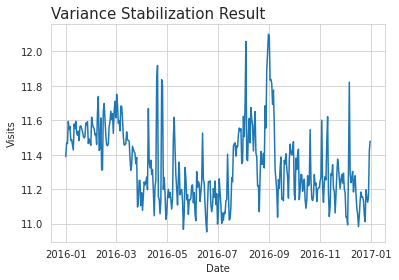

In [13]:
# variance stabilization
ma = main['Visits'].rolling(window = 121, min_periods = 1).mean()
mv = main['Visits'].rolling(window = 121, min_periods = 1).std()
sns.lineplot(x=main.index, y= main['Visits'],ci=None)
plt.title('Variance Stabilization Result', fontsize = 15, loc = 'left')
plt.show()

<Figure size 720x720 with 0 Axes>

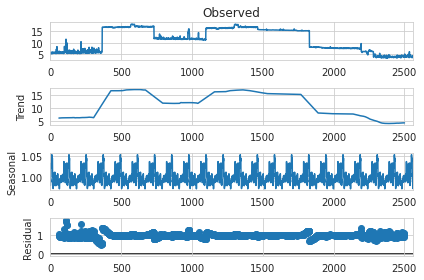

In [32]:
result = seasonal_decompose(main['Visits'].tolist(), model='multiplicative', filt=None, freq= 121)

plt.figure(figsize = (10,10))
fig = result.plot()
plt.show()

### (3) ARIMA


1.   Stationary Test 및 ACF/PACF
2.   seasonal differencing & test
3.   parameter p,d,q 결정



In [15]:
# ADF test 기각 --> 비정상성 
from statsmodels.tsa.stattools import adfuller
adf = adfuller(main['Visits'].tolist())
print('ADF statistics: ',adf[0])
print('p-value: ',adf[1])

ADF statistics:  -1.3285177387355493
p-value:  0.6160265507145031


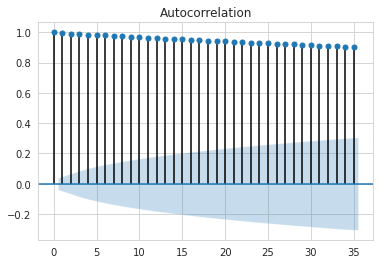

In [16]:
plot_acf(main['Visits'])
plt.show()

#### 1차 차분

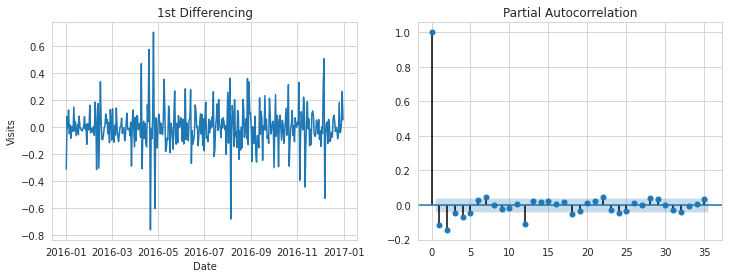

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4))
sns.lineplot(x = main.index, y = main['Visits'].diff(), ci = None, ax = ax[0])
ax[0].set_title('1st Differencing')
plot_pacf(main['Visits'].diff().dropna(), ax = ax[1])
plt.show()

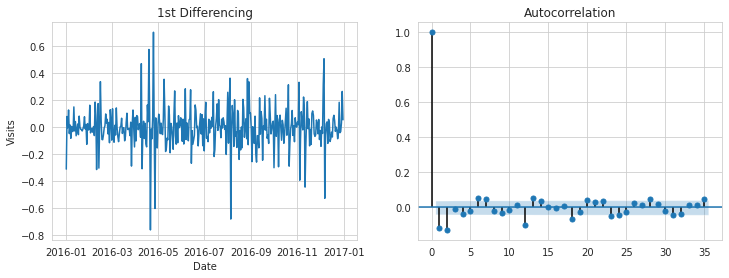

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4))
sns.lineplot(x = main.index, y = main['Visits'].diff(), ci = None, ax = ax[0])
ax[0].set_title('1st Differencing')
plot_acf(main['Visits'].diff().dropna(), ax = ax[1])
plt.show()

In [19]:
# 정상성 만족
adf = adfuller(main['Visits'].diff().dropna().tolist())
print('ADF statistics: ',adf[0])
print('p-value: ',adf[1])

ADF statistics:  -11.343403064522741
p-value:  1.0411603052585589e-20


#### ARIMA 적용

In [44]:
# ARIMA
model = ARIMA(main['Visits'], order = (0,1,2))
model_fit = model.fit(trend='c', disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Visits   No. Observations:                 2561
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1664.637
Method:                       css-mle   S.D. of innovations              0.463
Date:                Fri, 08 Jan 2021   AIC                           3337.274
Time:                        03:44:28   BIC                           3360.667
Sample:                             1   HQIC                          3345.756
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.006     -0.080      0.936      -0.013       0.012
ma.L1.D.Visits    -0.1493      0.020     -7.641      0.000      -0.188      -0.111
ma.L2.D.Visits    -0.1485      0.020

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


In [55]:
import pmdarima as pm
model = pm.auto_arima(main['Visits'].tolist(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m= 1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal = False,
                      start_P=0, 
                      D= 0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3345.104, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3436.946, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3402.962, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3388.710, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3434.948, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3338.697, Time=2.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3351.132, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3340.311, Time=1.95 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3339.079, Time=2.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3337.824, Time=1.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3337.274, Time=0.79 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3338.232, Time=0.96 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3339.613, Time=2.92 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3335.281, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0]          

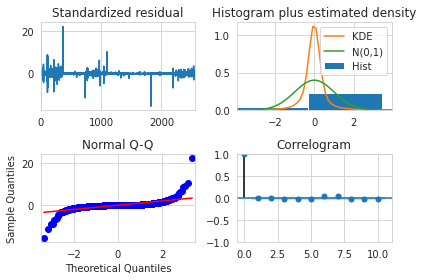

In [43]:
# check assumptions for white noise
model.plot_diagnostics()
plt.tight_layout()
plt.show()